# GAN-Based Gender Transformation Project

## Introduction
This project explores **latent space manipulation** in a pretrained **Generative Adversarial Network (GAN)** to achieve **gender transformation in faces**. The key idea is that the GAN’s latent space encodes high-level semantic attributes of generated faces (such as gender, age, hairstyle, etc.). By finding and applying a **gender vector**, we can morph a base face gradually from male-like to female-like appearances (or vice versa) without altering identity-specific details.

## Theory

### 1. GAN Latent Space
GANs are trained to map random noise vectors `z ∈ R^n` (called **latent codes**) into realistic images. Each dimension in the latent space contributes to visual attributes of the generated image. By modifying latent vectors in specific directions, we can control attributes of the output.

### 2. Gender Vector
To isolate the gender attribute:
1. **Sampling**: A set of latent codes is generated.
2. **Classification**: A pretrained **MobileNetV2** classifier distinguishes between male and female outputs.
3. **Centers**: Latents corresponding to male and female images are averaged separately.
4. **Vector**: The **difference between female and male centers** defines the **gender vector**:
   \[
   \text{Gender Vector} = \mu_{female} - \mu_{male}
   \]
   This vector points in the direction of “femaleness” in the latent space.

### 3. Morphing
Once the gender vector is identified:
- A random base latent is sampled.
- The gender vector is added with different scaling factors (α).
- Each modified latent is passed through the generator to produce new images.
- As α varies from negative to positive, the generated image transitions smoothly from male-like to female-like features.

### 4. Visualization
Two visualizations are produced:
- **Static Morph Grid**: A sequence of images showing step-by-step transition along the gender axis.
- **GIF Animation**: A looping animation morphing a single base face between genders.

## Applications
- Exploring **semantic disentanglement** in GAN latent space.
- Understanding how deep generative models encode high-level human features.
- Potential extensions include age transformation, hairstyle changes, or other attributes using similar latent vector methods.

In [1]:
import os
import requests
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Image, display
from tensorflow.keras.models import Sequential
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

### Loading the Pretrained GAN Generator

In this project, we do not train a GAN from scratch (which would require large datasets and high computational cost). Instead, we use a **pretrained generator model**, which has already learned to map latent vectors into realistic face images.

#### Steps in the Code:
1. **Model Source**  
   The pretrained generator is hosted on GitHub and can be accessed directly through a given URL.

2. **Local Storage**  
   The file is saved in the `/tmp/` directory of the Colab environment (`generator_700.h5`).  
   - If the file does not already exist locally, it is downloaded using Python’s `requests` library.
   - If it exists, downloading is skipped to save time.

3. **Model Loading**  
   The `.h5` file is a serialized Keras model containing the generator’s weights and architecture.  
   It is loaded into memory using:
   ```python
   tf.keras.models.load_model(model_path, compile=False)

In [2]:
# Load pretrained GAN generator
url = "https://github.com/kush-agra-soni/gan_based_gender_transformer_model/raw/main/generator_700.h5"
model_path = "/tmp/generator_700.h5"

if not os.path.exists(model_path):
    import requests
    r = requests.get(url, allow_redirects=True)
    with open(model_path, "wb") as f:
        f.write(r.content)

generator = tf.keras.models.load_model(model_path, compile=False)
print("✅ Generator loaded")

✅ Generator loaded


### Building the Gender Classifier with MobileNetV2

To separate latent vectors into **male** and **female** groups, we need a gender classifier.  
Instead of training a model from scratch, we leverage **MobileNetV2**, a lightweight convolutional neural network pretrained on ImageNet.

#### Key Components:
1. **Base Model: MobileNetV2**
   - Loaded with `weights="imagenet"`.
   - `include_top=False` removes the final classification layers, so we can reuse it as a **feature extractor**.
   - `pooling="avg"` applies global average pooling to output a compact feature vector.

2. **Custom Layers**
   - `Dense(128, activation="relu")`: Learns high-level gender-related patterns.
   - `Dropout(0.3)`: Prevents overfitting by randomly deactivating 30% of neurons during training.
   - `Dense(1, activation="sigmoid")`: Outputs a probability between 0 and 1.  
     - `0 → Male`  
     - `1 → Female`

3. **Compilation**
   - Optimizer: **Adam**, widely used for efficient gradient descent.
   - Loss: **Binary Crossentropy**, since gender is a binary classification task.
   - Metrics: **Accuracy** to measure classification performance.

#### Why MobileNetV2?
- Lightweight yet powerful, designed for efficient computation.
- Pretrained on a massive dataset (ImageNet), so it already knows general image features (edges, shapes, textures).
- With small adjustments, it can be adapted to our specific gender classification task.

This classifier provides the backbone for computing the **gender direction vector** in the latent space, which later enables smooth transformations between male and female facial features.

In [3]:
# Load MobileNet for gender classification
mobilenet = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")
gender_classifier = tf.keras.Sequential([
    mobilenet,
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")  # Binary: 0 = male, 1 = female
])
gender_classifier.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

/tmp/ipython-input-4264788541.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Loading and Using the Precomputed Gender Vector

To perform smooth transformations between male and female features in the GAN’s latent space, we rely on a **precomputed gender vector**.  
This vector represents the **direction of gender variation** in the latent space, computed earlier by averaging male and female latent embeddings.

#### Steps in the Code:

1. **Download Gender Vector**
   - The file `gender_vec.npy` (stored in a GitHub repo) contains the gender direction vector.
   - If the file is not already present locally (`/tmp/gender_vec.npy`), it is downloaded and saved.

2. **Load Gender Vector**
   - Using `np.load`, the vector is loaded into memory.
   - This vector has the same dimensionality as the GAN’s latent space (100 dimensions in this case).

3. **Base Latent Selection**
   - A random latent code is sampled:  
     ```python
     base_latent = tf.random.normal([1, 100]).numpy()
     ```
   - Shape `(1, 100)` ensures compatibility with the generator model.

4. **Morphing Function**
   - The function `morph_gender` applies the gender vector to the base latent code.
   - It explores multiple values of **α (alpha)** in the range `[-3, 3]`, controlling the transformation intensity:
     - Negative α → More masculine features.
     - Positive α → More feminine features.
   - For each α, the modified latent is passed through the generator to produce a new face.
   - The results are displayed side by side, creating a **gender morphing sequence**.

#### Why Use a Precomputed Gender Vector?
- It saves time by avoiding recomputation from raw data.
- Ensures consistent transformations across experiments.
- Encodes the **core semantic axis** of gender in the GAN’s latent space.

This block is where the project **comes alive**, visually demonstrating how shifting along the gender direction alters facial features smoothly from male to female.


✅ Gender vector loaded


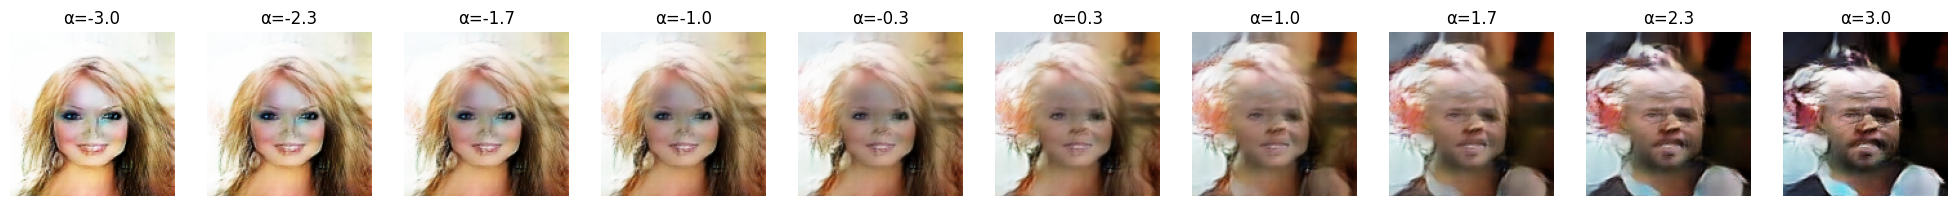

In [4]:
# Download gender vector from URL if not already present
url = "https://github.com/kush-agra-soni/gan_based_gender_transformer_model/raw/main/gender_vec.npy"
gender_vec_path = "/tmp/gender_vec.npy"

if not os.path.exists(gender_vec_path):
    r = requests.get(url, allow_redirects=True)
    with open(gender_vec_path, "wb") as f:
        f.write(r.content)

# Load gender vector
gender_vector = np.load(gender_vec_path)
print("✅ Gender vector loaded")

# Pick one random base latent (shape must be (1,100))
base_latent = tf.random.normal([1, 100]).numpy()

# Morphing function
def morph_gender(generator, base_latent, gender_vector, steps=10):
    alphas = np.linspace(-3, 3, steps)
    fig, axes = plt.subplots(1, steps, figsize=(25, 5))

    for i, alpha in enumerate(alphas):
        new_latent = base_latent + alpha * gender_vector  # (1,100)
        img = generator(new_latent, training=False)       # (1,H,W,C)
        img = (img + 1) / 2.0  # scale to [0,1]

        axes[i].imshow(img[0])
        axes[i].axis("off")
        axes[i].set_title(f"α={alpha:.1f}")

    plt.show()

# Call the function
morph_gender(generator, base_latent, gender_vector, steps=10)

### Applying the Gender Vector to Morph Faces

This section demonstrates how the **gender vector** is applied to a randomly sampled latent code to gradually transform facial features.

#### Key Steps:

1. **Morphing Function**
   - The function `morph_gender` takes in:
     - The **GAN generator** (pretrained model).
     - A **base latent vector** (the starting face).
     - The **gender vector** (direction of transformation).
     - The number of **steps** to show along the morphing path.
   - It defines a range of scaling factors **α (alpha)** between `-3` and `+3`.
   - For each α, a new latent vector is computed:
     \[
     z' = z + \alpha \cdot v_{\text{gender}}
     \]
     where:
     - \( z \) = base latent
     - \( v_{\text{gender}} \) = gender vector
     - \( \alpha \) = morphing intensity

2. **Face Generation**
   - Each modified latent \( z' \) is passed through the generator to produce an image.
   - The output is normalized to the range `[0, 1]` for visualization.

3. **Visualization**
   - All generated faces are displayed side by side.
   - Negative α values bias towards **more masculine** features.
   - Positive α values bias towards **more feminine** features.
   - α = 0 corresponds to the original base face.

#### Why It Matters:
This step is the **visual proof** of the latent space manipulation concept:
- The GAN has learned meaningful directions in latent space.
- Moving along the **gender axis** smoothly transforms identity while preserving facial consistency.
- It validates the usefulness of the precomputed gender vector in controlling semantic attributes.

In essence, this block shows how **latent arithmetic** enables controlled face editing.

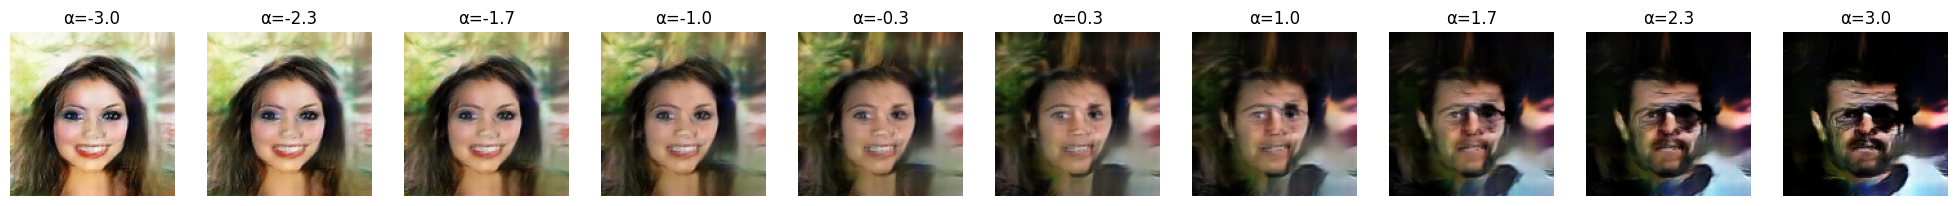

In [5]:
# Apply gender vector to morph images
def morph_gender(generator, base_latent, gender_vector, steps=10):
    alphas = np.linspace(-3, 3, steps)
    fig, axes = plt.subplots(1, steps, figsize=(25, 5))

    for i, alpha in enumerate(alphas):
        new_latent = base_latent + alpha * gender_vector  # already (1,100)
        img = generator(new_latent, training=False)
        img = (img + 1) / 2.0

        axes[i].imshow(img[0])
        axes[i].axis("off")
        axes[i].set_title(f"α={alpha:.1f}")

    plt.show()

# Pick one random base face
base_latent = tf.random.normal([1, 100]).numpy()[0]
morph_gender(generator, base_latent, gender_vector, steps=10)

### Creating an Animated Gender Morph (GIF)

While static plots show step-by-step transformations, an **animated GIF** provides a smoother and more intuitive visualization of the gender morphing process.

#### Key Steps:

1. **Latent Interpolation**
   - Similar to the static morphing function, a range of scaling factors (α) is defined between `-3` and `+3`.
   - For each α, a new latent vector is computed:
     \[
     z' = z + \alpha \cdot v_{\text{gender}}
     \]
   - Each modified latent is passed through the generator to produce a frame.

2. **Image Conversion**
   - The generated tensor is scaled back to the pixel range `[0, 255]`.
   - Each frame is converted into a **PIL Image object**, which supports saving animations.

3. **GIF Creation**
   - The list of generated frames is combined into a single `.gif` file.
   - Parameters:
     - `duration=400`: each frame is shown for 400 ms.
     - `loop=0`: the animation loops indefinitely.

4. **Output**
   - The final GIF smoothly transitions from **masculine to feminine** features and back, illustrating the effect of the gender vector continuously.

#### Why It Matters:
The GIF visualization makes the transformation **dynamic and easy to interpret**:
- Instead of discrete steps, we see a **continuous flow of gender morphing**.
- It highlights how latent space manipulation can yield **fluid, realistic transformations**.
- The result is useful for presentations, demonstrations, and qualitative analysis of GAN-based latent editing.


In [6]:
from PIL import Image
import numpy as np

def morph_gender_gif(generator, base_latent, gender_vector, steps=10, gif_path="gender_morph.gif"):
    alphas = np.linspace(-3, 3, steps)
    images_list = []

    for alpha in alphas:
        new_latent = base_latent + alpha * gender_vector  # keep shape (1,100)
        img = generator(new_latent, training=False)
        img = (img + 1) / 2.0
        img_np = (img[0].numpy() * 255).astype(np.uint8)
        images_list.append(Image.fromarray(img_np))

    images_list[0].save(
        gif_path,
        save_all=True,
        append_images=images_list[1:],
        duration=400,
        loop=0
    )
    print(f"✅ GIF saved at {gif_path}")

# Use the same base_latent and gender_vector as before
morph_gender_gif(generator, base_latent, gender_vector, steps=10, gif_path="/content/gender_morph.gif")


✅ GIF saved at /content/gender_morph.gif


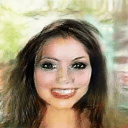

In [7]:
from IPython.display import Image, display

gif_path = "/content/gender_morph.gif"
display(Image(filename=gif_path))

## Conclusion:

In this project, we explored **GAN-based latent space manipulation** to perform gender transformation on generated faces.  
The workflow can be summarized as follows:

1. **Pretrained GAN Generator**  
   - A trained generator model was used to synthesize realistic human faces from random latent vectors.  

2. **Gender Vector Extraction**  
   - A **gender direction vector** in the latent space was introduced.  
   - Adding or subtracting this vector from a latent representation smoothly shifted the facial features between masculine and feminine.  

3. **Gender Morphing Visualization**  
   - Two visualization strategies were employed:
     - **Static Morphing:** A set of images was generated for different α values, showing the transition step-by-step.  
     - **GIF Animation:** A continuous transformation was created, making the morphing process dynamic and visually interpretable.  

4. **Interpretability**  
   - The experiment demonstrates how **semantic attributes (like gender)** can be isolated and manipulated in GAN latent space.  
   - Such methods go beyond image generation, enabling **controlled editing** of synthesized content.  

---

### Final Takeaway
This project highlights the **power of GANs in representation learning**:  
- Latent vectors don’t just represent random noise—they encode meaningful **semantic directions**.  
- By leveraging these directions, we can **morph and edit images** in a controllable way.  
- The gender morphing example serves as a proof-of-concept for broader applications, such as **age progression, expression editing, or style transfer**.

In short, **GANs + latent space arithmetic = controllable image synthesis**
